In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os
import warnings

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from xgboost import XGBRegressor

In [2]:
path = '../Data'

csv_files = glob.glob(path + "/*.csv")
to_remove = ['../Data/game_lineups.csv',
             '../Data/game_events.csv',
             '../Data/games.csv',
             '../Data/club_games.csv'
            ]
csv_files = [x for x in csv_files if x not in to_remove]

# Create an empty dictionary to store the DataFrames
dataframes = {}

for file in csv_files:
  # Get the base name of the file
  base_name = os.path.basename(file)
  
  # Remove the .csv extension to get the clean name
  # and add '_df' to match your requested format
  df_name = f"{os.path.splitext(base_name)[0]}_df"
  
  # Read the csv and add it to the dictionary
  dataframes[df_name] = pd.read_csv(file)

print("Available DataFrames:", list(dataframes.keys()))

Available DataFrames: ['competitions_df', 'appearances_df', 'player_valuations_df', 'transfers_df', 'players_df', 'clubs_df']


In [3]:
# Unpack the dictionary into separate global variables
for name, df in dataframes.items():
  globals()[name] = df

In [4]:
competitions_df.head()

,competition_id,competition_code,name,sub_type,type,country_id,country_name,domestic_league_code,confederation,url,is_major_national_league
0,CIT,italy-cup,italy-cup,domestic_cup,domestic_cup,75,Italy,IT1,europa,https://www.transfermarkt.co.uk/italy-cup/star...,False
1,NLSC,johan-cruijff-schaal,johan-cruijff-schaal,domestic_super_cup,other,122,Netherlands,NL1,europa,https://www.transfermarkt.co.uk/johan-cruijff-...,False
2,GRP,kypello-elladas,kypello-elladas,domestic_cup,domestic_cup,56,Greece,GR1,europa,https://www.transfermarkt.co.uk/kypello-ellada...,False
3,POSU,supertaca-candido-de-oliveira,supertaca-candido-de-oliveira,domestic_super_cup,other,136,Portugal,PO1,europa,https://www.transfermarkt.co.uk/supertaca-cand...,False
4,RUSS,russian-super-cup,russian-super-cup,domestic_super_cup,other,141,Russia,RU1,europa,https://www.transfermarkt.co.uk/russian-super-...,False


In [5]:
for name, df_object in dataframes.items():
    print(f"--- Analyzing: {name} ---")
    print("Head:")
    print(df_object.head())
    print("\nInfo:")
    df_object.info()
    print("\nDescribe:")
    print(df_object.describe())
    print("\n" + "="*50 + "\n")

--- Analyzing: competitions_df ---
Head:
  competition_id               competition_code  \
0            CIT                      italy-cup   
1           NLSC           johan-cruijff-schaal   
2            GRP                kypello-elladas   
3           POSU  supertaca-candido-de-oliveira   
4           RUSS              russian-super-cup   

                            name            sub_type          type  \
0                      italy-cup        domestic_cup  domestic_cup   
1           johan-cruijff-schaal  domestic_super_cup         other   
2                kypello-elladas        domestic_cup  domestic_cup   
3  supertaca-candido-de-oliveira  domestic_super_cup         other   
4              russian-super-cup  domestic_super_cup         other   

   country_id country_name domestic_league_code confederation  \
0          75        Italy                  IT1        europa   
1         122  Netherlands                  NL1        europa   
2          56       Greece          

In [6]:
#Dropping unsued columns
players_df.drop(columns = ['first_name', 'last_name','player_code', 'image_url', 'url'], inplace = True)
competitions_df.drop(columns = ['competition_code','sub_type', 'url'], inplace=True)
clubs_df.drop(columns = ['filename', 'url'], inplace=True)

In [7]:
for name, df_object in dataframes.items():
    print(f"--- Null Rows for {name} ---")
    null_rows = df_object[df_object.isnull().any(axis=1)]
    print(null_rows)

--- Null Rows for competitions_df ---
   competition_id                                         name  \
6             USC                               uefa-super-cup   
8              EL                                europa-league   
17           UCOL                       uefa-conference-league   
18            ELQ                  europa-league-qualifikation   
21           ECLQ  uefa-europa-conference-league-qualifikation   
27             CL                        uefa-champions-league   
32           KLUB                                 fifa-klub-wm   
38            CLQ          uefa-champions-league-qualifikation   

                 type  country_id country_name domestic_league_code  \
6   international_cup          -1          NaN                  NaN   
8   international_cup          -1          NaN                  NaN   
17  international_cup          -1          NaN                  NaN   
18  international_cup          -1          NaN                  NaN   
21  internat

### Notes: 
Null rows for competitions are international (rightfully N/A)

Six appearances rows for copa del rey cup do not have player names, but do have IDs. Can drop

For transfers_df, many null transfer fee and market_value_in_eur. May drop or impute missing values later.

For players_df, many null values. About half of agent_names are missing, contract_expiration_date also has high NaN %. Will need to examine separately. 

For clubs_df, some missing values including a completely NaN total_market_value and coach_name value. Will also need to look at separately.

In [8]:
appearances_df.dropna(inplace=True)

In [9]:
players_df.head()

,player_id,name,last_season,current_club_id,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,contract_expiration_date,agent_name,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
0,10,Miroslav Klose,2015,398,Poland,Opole,Germany,1978-06-09 00:00:00,Centre-Forward,Attack,right,184.0,NaN,ASBW Sport Marketing,IT1,Società Sportiva Lazio S.p.A.,1000000.0,30000000.0
1,26,Roman Weidenfeller,2017,16,Germany,Diez,Germany,1980-08-06 00:00:00,Goalkeeper,Goalkeeper,left,190.0,NaN,Neubauer 13 GmbH,L1,Borussia Dortmund,750000.0,8000000.0
2,65,Dimitar Berbatov,2015,1091,Bulgaria,Blagoevgrad,Bulgaria,1981-01-30 00:00:00,Centre-Forward,Attack,NaN,NaN,NaN,CSKA-AS-23 Ltd.,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,1000000.0,34500000.0
3,77,Lúcio,2012,506,Brazil,Brasília,Brazil,1978-05-08 00:00:00,Centre-Back,Defender,NaN,NaN,NaN,NaN,IT1,Juventus Football Club,200000.0,24500000.0
4,80,Tom Starke,2017,27,East Germany (GDR),Freital,Germany,1981-03-18 00:00:00,Goalkeeper,Goalkeeper,right,194.0,NaN,IFM,L1,FC Bayern München,100000.0,3000000.0


In [10]:
players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32601 entries, 0 to 32600
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   player_id                             32601 non-null  int64  
 1   name                                  32601 non-null  object 
 2   last_season                           32601 non-null  int64  
 3   current_club_id                       32601 non-null  int64  
 4   country_of_birth                      29802 non-null  object 
 5   city_of_birth                         30146 non-null  object 
 6   country_of_citizenship                32218 non-null  object 
 7   date_of_birth                         32554 non-null  object 
 8   sub_position                          32421 non-null  object 
 9   position                              32601 non-null  object 
 10  foot                                  30065 non-null  object 
 11  height_in_cm   

In [11]:
players_df.isnull().sum()

player_id                                   0
name                                        0
last_season                                 0
current_club_id                             0
country_of_birth                         2799
city_of_birth                            2455
country_of_citizenship                    383
date_of_birth                              47
sub_position                              180
position                                    0
foot                                     2536
height_in_cm                             2256
contract_expiration_date                12091
agent_name                              16019
current_club_domestic_competition_id        0
current_club_name                           0
market_value_in_eur                      1523
highest_market_value_in_eur              1523
dtype: int64

In [12]:
# Create a boolean mask where the condition is True
mask = players_df['country_of_birth'] == players_df['country_of_citizenship']

# Sum the True values (since True=1, False=0) to get the count
count = mask.sum()

print(f"Number of rows where birth country equals citizenship: {count}")

Number of rows where birth country equals citizenship: 24677


In [13]:
players_df['country_of_birth'] = players_df['country_of_birth'].fillna(players_df['country_of_citizenship'])

In [14]:
players_df.isnull().sum()

player_id                                   0
name                                        0
last_season                                 0
current_club_id                             0
country_of_birth                          382
city_of_birth                            2455
country_of_citizenship                    383
date_of_birth                              47
sub_position                              180
position                                    0
foot                                     2536
height_in_cm                             2256
contract_expiration_date                12091
agent_name                              16019
current_club_domestic_competition_id        0
current_club_name                           0
market_value_in_eur                      1523
highest_market_value_in_eur              1523
dtype: int64

In [15]:
players_df = players_df.dropna(subset=['country_of_birth', 'country_of_citizenship'])

In [16]:
players_df['country_of_birth'][players_df['city_of_birth'].isna()].value_counts()

country_of_birth
Denmark        507
Belgium        369
Greece         183
Ukraine        141
Netherlands    141
              ... 
Angola           1
Luxembourg       1
Japan            1
Chile            1
Moldova          1
Name: count, Length: 87, dtype: int64

city_of_birth is probably too granular than what we need, and does not seem to be randomly missing. Dropping column

In [17]:
players_df = players_df.drop(columns=['city_of_birth'])

In [18]:
players_df['position'][players_df['sub_position'].isna()].value_counts()

position
Missing    180
Name: count, dtype: int64

In [19]:
players_df = players_df.dropna(subset=['position', 'sub_position'])

In [20]:
players_df = players_df.dropna(subset=['date_of_birth'])

In [21]:
players_df['sub_position'][players_df['foot'].isna()].value_counts()

sub_position
Goalkeeper            529
Centre-Back           388
Centre-Forward        381
Central Midfield      298
Defensive Midfield    158
Attacking Midfield    156
Left Winger           137
Right-Back             98
Right Winger           95
Left-Back              82
Left Midfield          27
Right Midfield         27
Second Striker         11
Name: count, dtype: int64

In [22]:
players_df['foot'].value_counts()

foot
right    20835
left      7412
both      1363
Name: count, dtype: int64

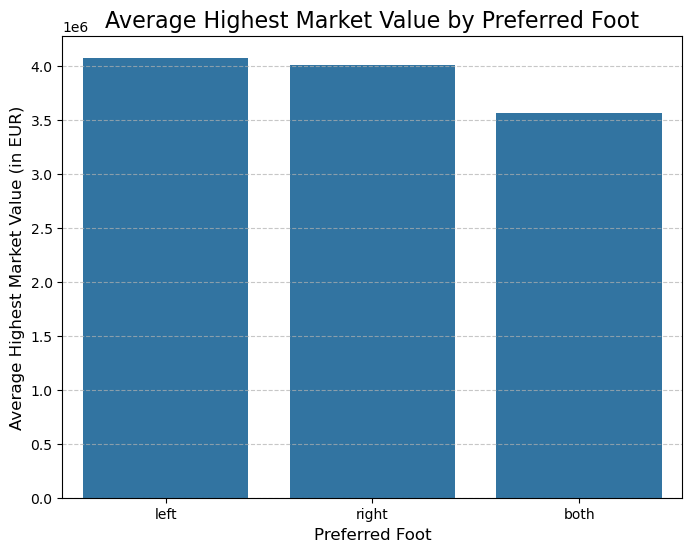

In [23]:
# Group by 'foot' and calculate the mean of the highest market value
avg_value_by_foot = players_df.groupby('foot')['highest_market_value_in_eur'].mean().reset_index()

# Sort the values for a cleaner plot
avg_value_by_foot = avg_value_by_foot.sort_values('highest_market_value_in_eur', ascending=False)


# --- Plotting ---
plt.figure(figsize=(8, 6))
sns.barplot(x='foot', y='highest_market_value_in_eur', data=avg_value_by_foot)

plt.title('Average Highest Market Value by Preferred Foot', fontsize=16)
plt.xlabel('Preferred Foot', fontsize=12)
plt.ylabel('Average Highest Market Value (in EUR)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [24]:
avg_value_by_foot

,foot,highest_market_value_in_eur
1,left,4.072432e+06
2,right,4.003072e+06
0,both,3.564317e+06


In [25]:
#too many values to drop, going to impute 'unknown' cat
players_df['foot'] = players_df['foot'].fillna('Unknown')

In [26]:
#height_in_cm can be replaced with averages. 
#Since players' positions can be a good indicator of height, we'll use average by sub_position
imputed_height = players_df.groupby('sub_position')['height_in_cm'].transform('mean')

# Fill the NaN values in the original column using this new series
players_df['height_in_cm'] = players_df['height_in_cm'].fillna(imputed_height)

In [27]:
# Get today's date
today = pd.to_datetime('today')

# Ensure the contract expiration date column is in datetime format
players_df['contract_expiration_date'] = pd.to_datetime(players_df['contract_expiration_date'])


# --- 1. Feature Engineering: Calculate Contract Days Remaining ---
# Create a new feature for the number of days left on the contract from today
players_df['contract_days_remaining'] = (players_df['contract_expiration_date'] - today).dt.days


# --- 2. Handle the Missing Values ---

# Step A: Create a binary flag for missing contract data
players_df['contract_info_missing'] = players_df['contract_days_remaining'].isnull().astype(int)


# Step B: Impute the missing values in the 'contract_days_remaining' column
# Filling with the median is a robust choice
median_contract_days = players_df['contract_days_remaining'].median()
players_df['contract_days_remaining'] = players_df['contract_days_remaining'].fillna(median_contract_days)


# Drop the original, less useful date column.
players_df = players_df.drop(columns=['contract_expiration_date'])

players_df.head()

,player_id,name,last_season,current_club_id,country_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,agent_name,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur,contract_days_remaining,contract_info_missing
0,10,Miroslav Klose,2015,398,Poland,Germany,1978-06-09 00:00:00,Centre-Forward,Attack,right,184.000000,ASBW Sport Marketing,IT1,Società Sportiva Lazio S.p.A.,1000000.0,30000000.0,-24.0,1
1,26,Roman Weidenfeller,2017,16,Germany,Germany,1980-08-06 00:00:00,Goalkeeper,Goalkeeper,left,190.000000,Neubauer 13 GmbH,L1,Borussia Dortmund,750000.0,8000000.0,-24.0,1
2,65,Dimitar Berbatov,2015,1091,Bulgaria,Bulgaria,1981-01-30 00:00:00,Centre-Forward,Attack,Unknown,184.035063,CSKA-AS-23 Ltd.,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,1000000.0,34500000.0,-24.0,1
3,77,Lúcio,2012,506,Brazil,Brazil,1978-05-08 00:00:00,Centre-Back,Defender,Unknown,187.358271,NaN,IT1,Juventus Football Club,200000.0,24500000.0,-24.0,1
4,80,Tom Starke,2017,27,East Germany (GDR),Germany,1981-03-18 00:00:00,Goalkeeper,Goalkeeper,right,194.000000,IFM,L1,FC Bayern München,100000.0,3000000.0,-24.0,1


In [28]:
players_df['agent_name'] = players_df['agent_name'].fillna('Unknown')

In [29]:
players_df.isnull().sum()

player_id                                  0
name                                       0
last_season                                0
current_club_id                            0
country_of_birth                           0
country_of_citizenship                     0
date_of_birth                              0
sub_position                               0
position                                   0
foot                                       0
height_in_cm                               0
agent_name                                 0
current_club_domestic_competition_id       0
current_club_name                          0
market_value_in_eur                     1413
highest_market_value_in_eur             1413
contract_days_remaining                    0
contract_info_missing                      0
dtype: int64

I'm going to drop highest_market_value_in_eur. The goal is to effectively model player values, and this will lead to leakage. 

In [30]:
players_df = players_df.drop(columns=['highest_market_value_in_eur'])

In [31]:
players_df = players_df.dropna(subset=['market_value_in_eur'])

In [32]:
players_df.head()

,player_id,name,last_season,current_club_id,country_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,agent_name,current_club_domestic_competition_id,current_club_name,market_value_in_eur,contract_days_remaining,contract_info_missing
0,10,Miroslav Klose,2015,398,Poland,Germany,1978-06-09 00:00:00,Centre-Forward,Attack,right,184.000000,ASBW Sport Marketing,IT1,Società Sportiva Lazio S.p.A.,1000000.0,-24.0,1
1,26,Roman Weidenfeller,2017,16,Germany,Germany,1980-08-06 00:00:00,Goalkeeper,Goalkeeper,left,190.000000,Neubauer 13 GmbH,L1,Borussia Dortmund,750000.0,-24.0,1
2,65,Dimitar Berbatov,2015,1091,Bulgaria,Bulgaria,1981-01-30 00:00:00,Centre-Forward,Attack,Unknown,184.035063,CSKA-AS-23 Ltd.,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,1000000.0,-24.0,1
3,77,Lúcio,2012,506,Brazil,Brazil,1978-05-08 00:00:00,Centre-Back,Defender,Unknown,187.358271,Unknown,IT1,Juventus Football Club,200000.0,-24.0,1
4,80,Tom Starke,2017,27,East Germany (GDR),Germany,1981-03-18 00:00:00,Goalkeeper,Goalkeeper,right,194.000000,IFM,L1,FC Bayern München,100000.0,-24.0,1


We can grab some new features from other dfs

In [33]:
appearances_df.head()

,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
0,2231978_38004,2231978,38004,853,235,2012-07-03,Aurélien Joachim,CLQ,0,0,2,0,90
1,2233748_79232,2233748,79232,8841,2698,2012-07-05,Ruslan Abyshov,ELQ,0,0,0,0,90
2,2234413_42792,2234413,42792,6251,465,2012-07-05,Sander Puri,ELQ,0,0,0,0,45
3,2234418_73333,2234418,73333,1274,6646,2012-07-05,Vegar Hedenstad,ELQ,0,0,0,0,90
4,2234421_122011,2234421,122011,195,3008,2012-07-05,Markus Henriksen,ELQ,0,0,0,1,90


In [34]:
#Get totals for stats from appearances_df
sum_cols = ['yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played']

player_stats = appearances_df.groupby('player_id')[sum_cols].sum()
players_df = pd.merge(players_df, player_stats, on='player_id', how='left')
players_df[sum_cols] = players_df[sum_cols].fillna(0)

In [35]:
players_df.sort_values('goals', ascending=False).head()

,player_id,name,last_season,current_club_id,country_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,agent_name,current_club_domestic_competition_id,current_club_name,market_value_in_eur,contract_days_remaining,contract_info_missing,yellow_cards,red_cards,goals,assists,minutes_played
3223,38253,Robert Lewandowski,2024,131,Poland,Poland,1988-08-21 00:00:00,Centre-Forward,Attack,right,185.0,Gol International,ES1,Futbol Club Barcelona,15000000.0,341.0,0,59.0,1.0,507.0,118.0,51228.0
2325,28003,Lionel Messi,2022,583,Argentina,Argentina,1987-06-24 00:00:00,Right Winger,Attack,left,170.0,Unknown,FR1,Paris Saint-Germain Football Club,35000000.0,-24.0,1,49.0,1.0,451.0,224.0,44380.0
747,8198,Cristiano Ronaldo,2022,985,Portugal,Portugal,1985-02-05 00:00:00,Centre-Forward,Attack,right,187.0,Gestifute,GB1,Manchester United Football Club,15000000.0,-24.0,0,64.0,4.0,432.0,114.0,41150.0
9295,132098,Harry Kane,2024,27,England,England,1993-07-28 00:00:00,Centre-Forward,Attack,right,188.0,CK66,L1,FC Bayern München,90000000.0,706.0,0,52.0,0.0,346.0,85.0,39942.0
5140,58864,Pierre-Emerick Aubameyang,2023,244,France,Gabon,1989-06-18 00:00:00,Centre-Forward,Attack,right,187.0,Unknown,FR1,Olympique de Marseille,5000000.0,341.0,0,36.0,1.0,294.0,80.0,38613.0


In [36]:
players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'])

In [37]:
players_df['age_in_days'] = (today - players_df['date_of_birth']).dt.days
players_df = players_df.drop(columns=['date_of_birth'])

In [38]:
players_df.columns

Index(['player_id', 'name', 'last_season', 'current_club_id',
       'country_of_birth', 'country_of_citizenship', 'sub_position',
       'position', 'foot', 'height_in_cm', 'agent_name',
       'current_club_domestic_competition_id', 'current_club_name',
       'market_value_in_eur', 'contract_days_remaining',
       'contract_info_missing', 'yellow_cards', 'red_cards', 'goals',
       'assists', 'minutes_played', 'age_in_days'],
      dtype='object')

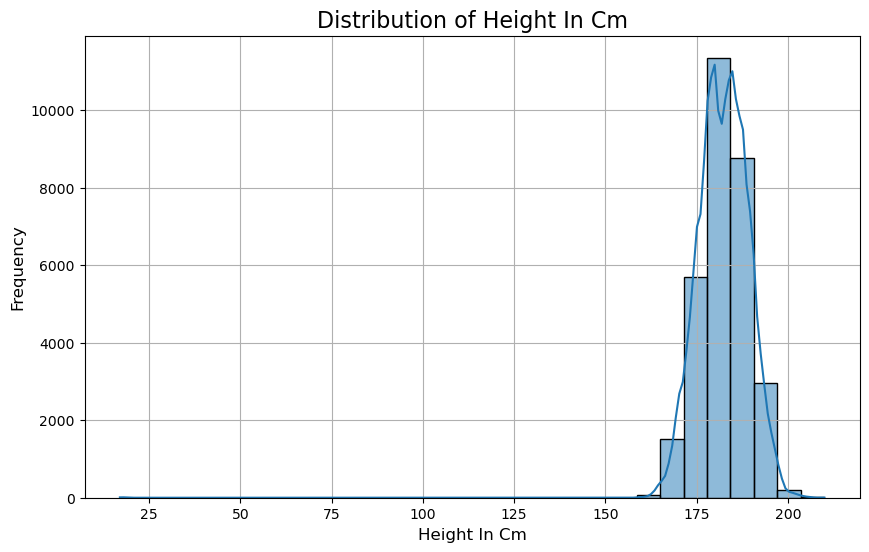

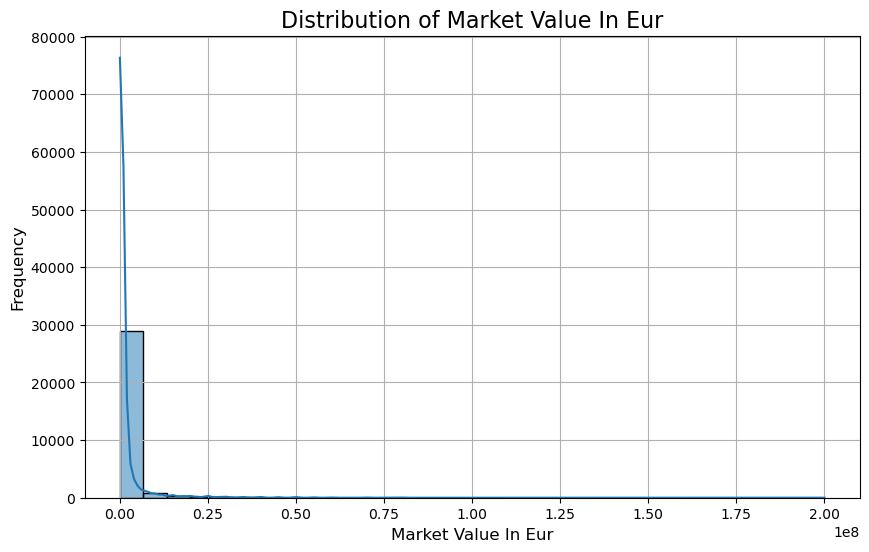

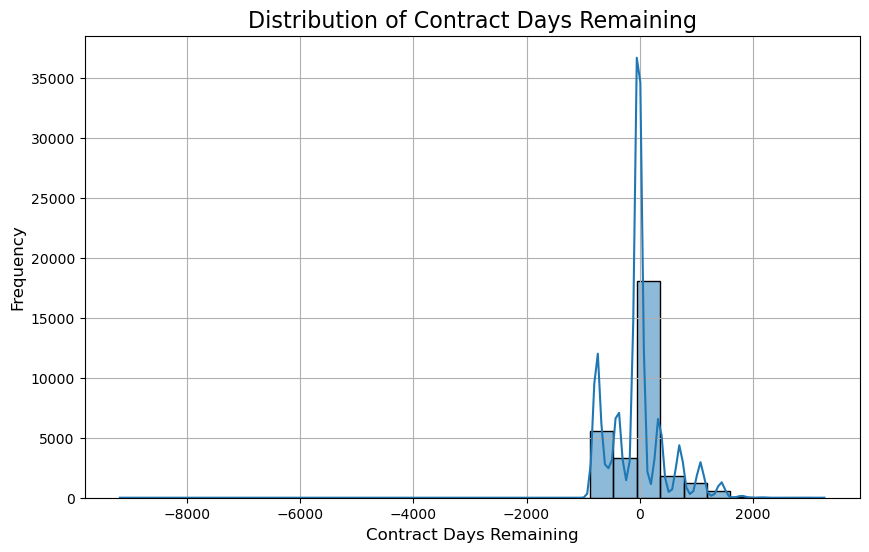

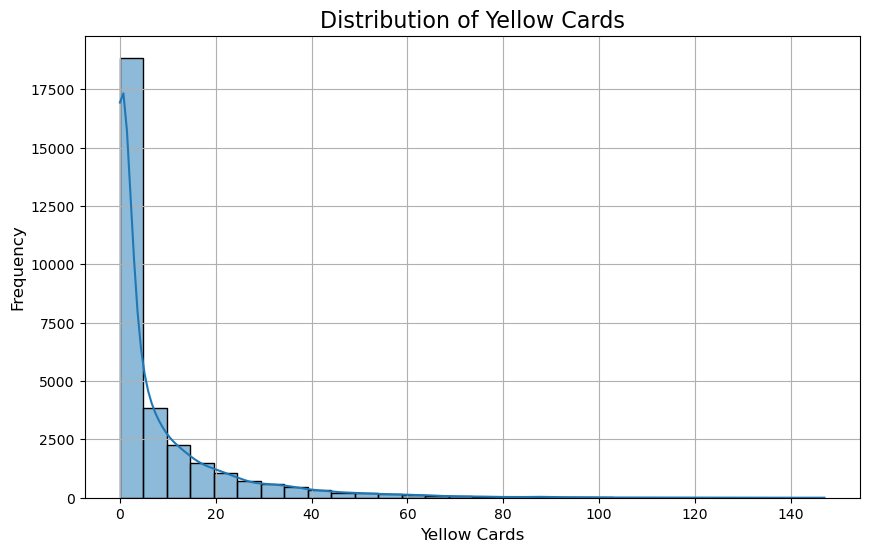

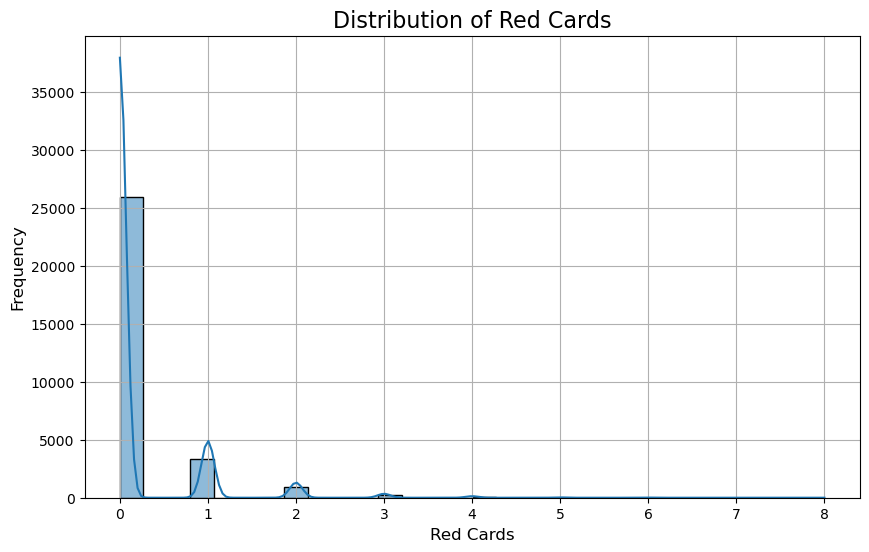

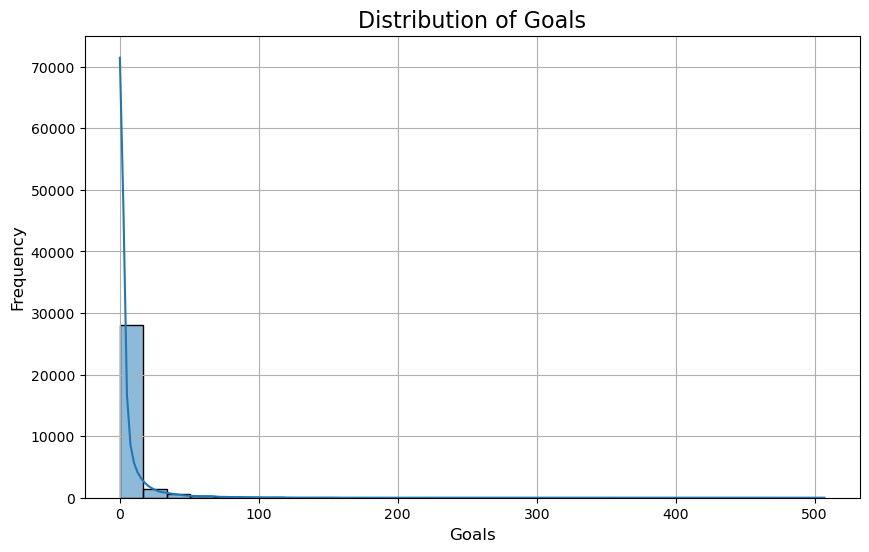

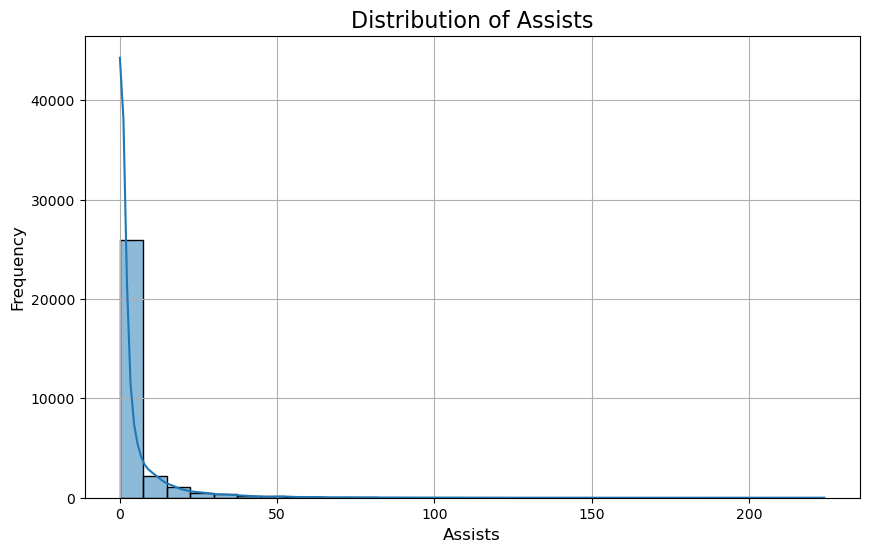

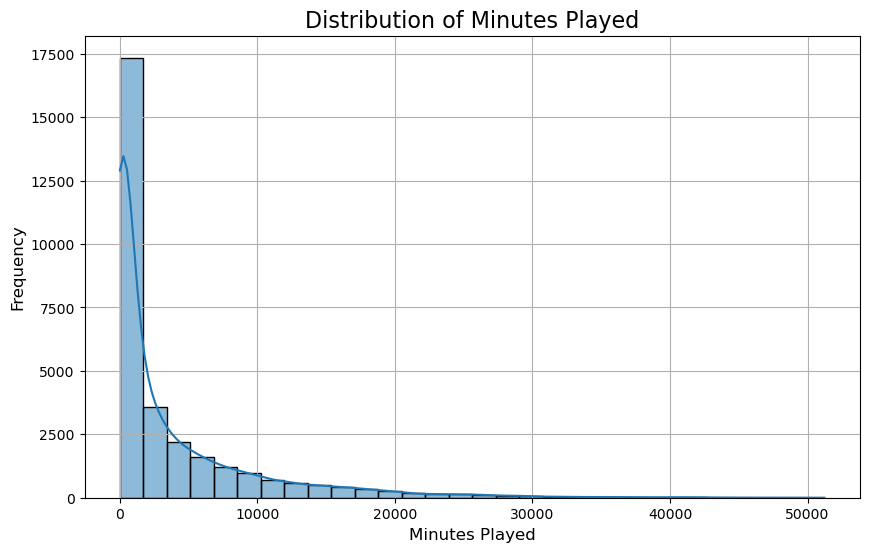

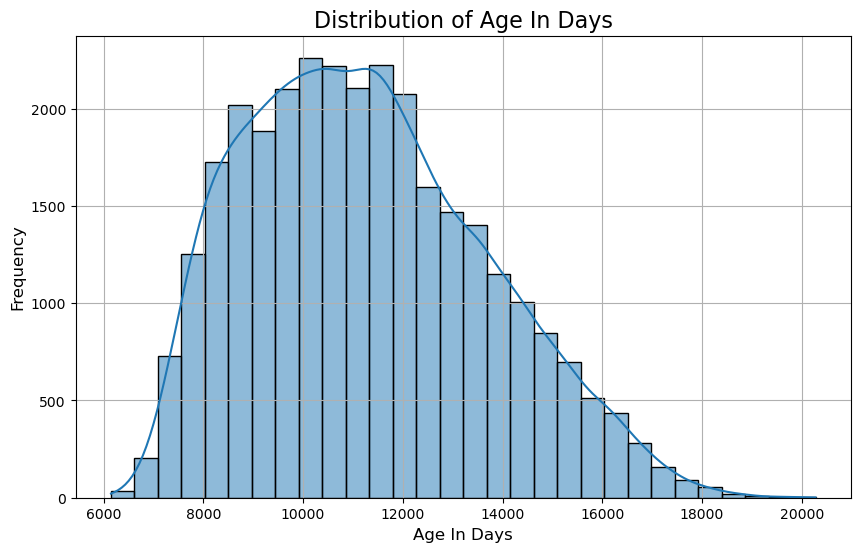

In [39]:
num_cols = [
    'height_in_cm', 'market_value_in_eur', 'contract_days_remaining', 
    'yellow_cards', 'red_cards', 'goals','assists', 'minutes_played', 
    'age_in_days'
]

cat_cols = [
    'current_club_id','country_of_birth', 'country_of_citizenship',
    'sub_position', 'position', 'foot', 'agent_name',
    'current_club_domestic_competition_id', 'current_club_name', 
    'contract_info_missing'
]

for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(players_df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col.replace("_", " ").title()}', fontsize=16)
    plt.xlabel(col.replace("_", " ").title(), fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True)
    plt.show()

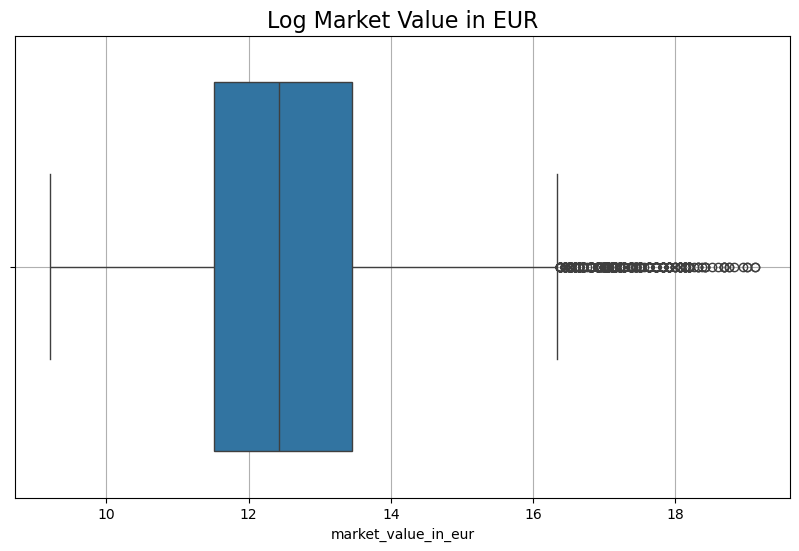

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=np.log1p(players_df['market_value_in_eur'])) 
plt.title('Log Market Value in EUR', fontsize=16)
plt.grid(True)
plt.show()

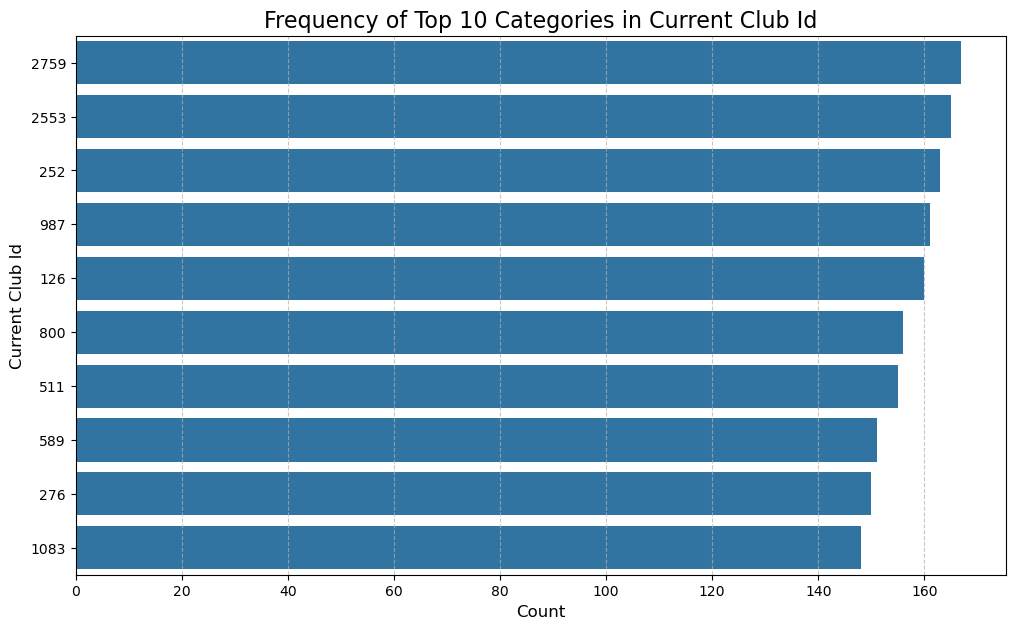

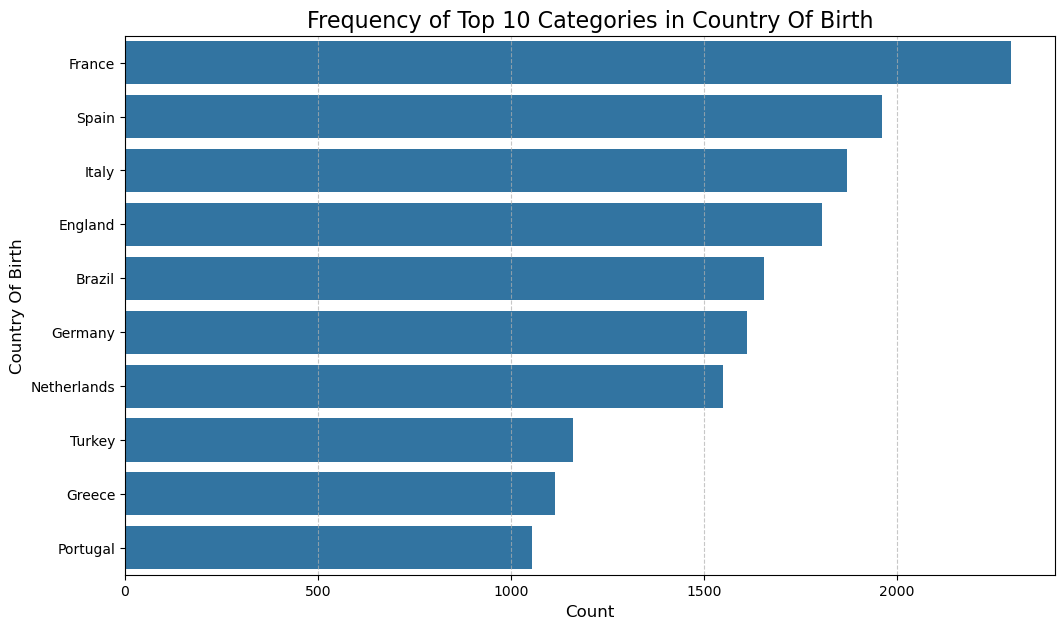

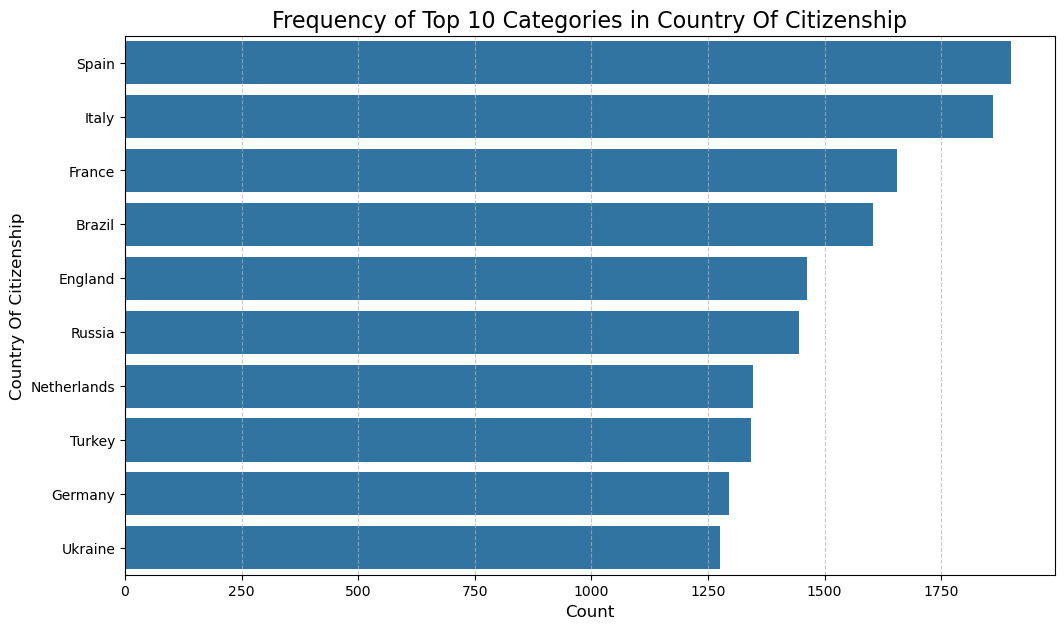

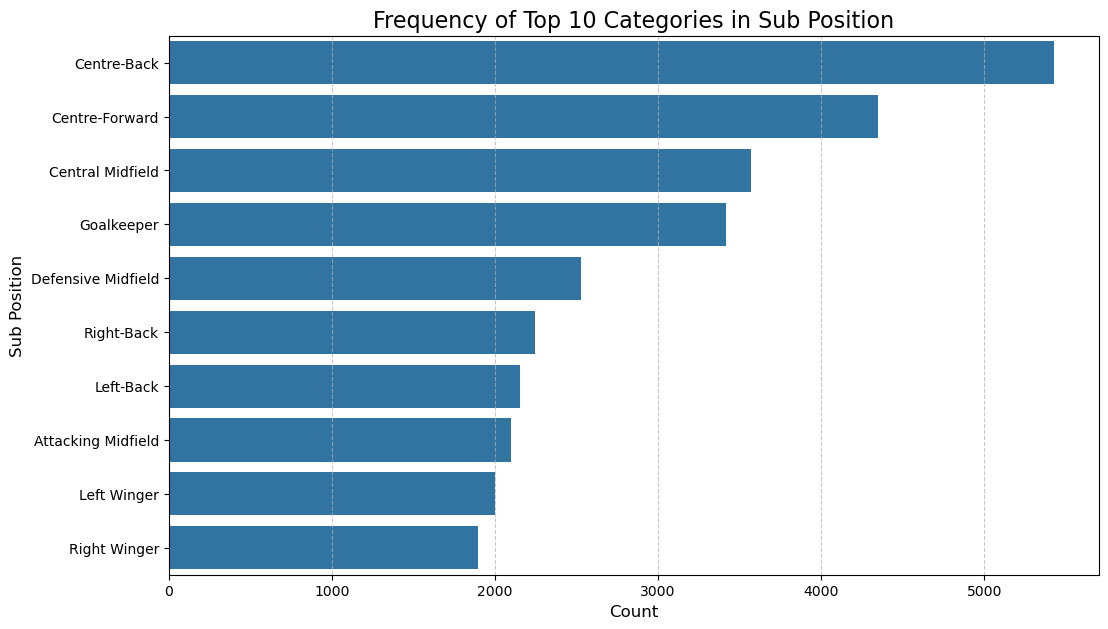

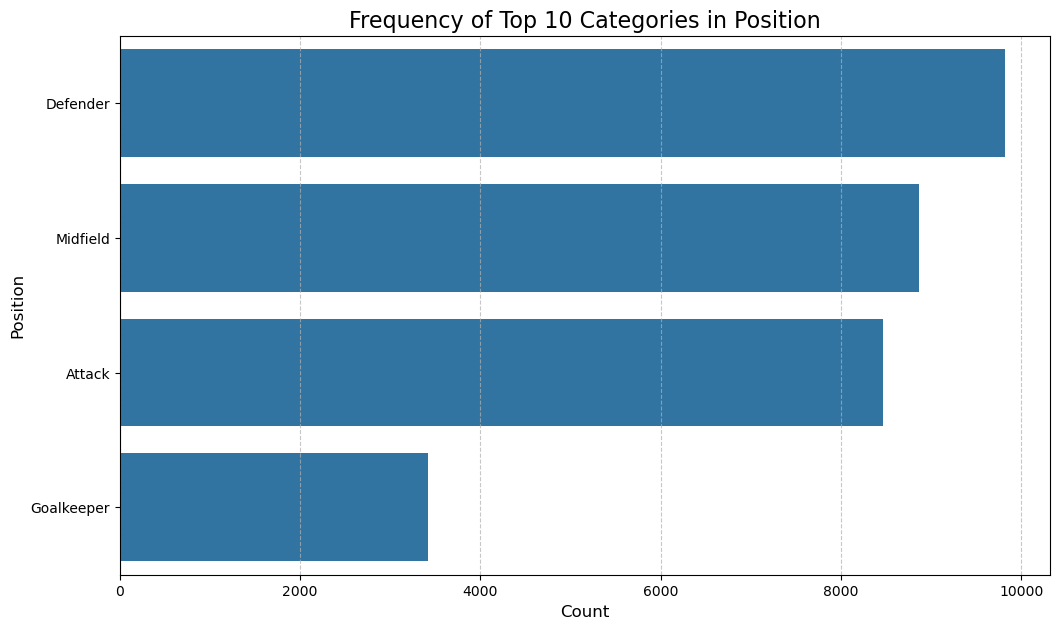

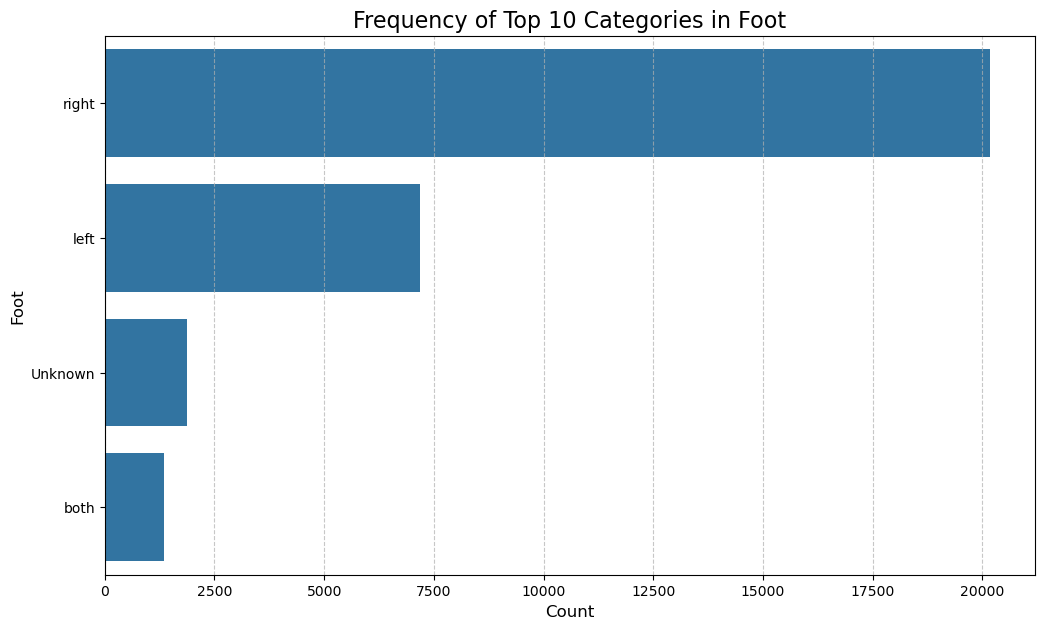

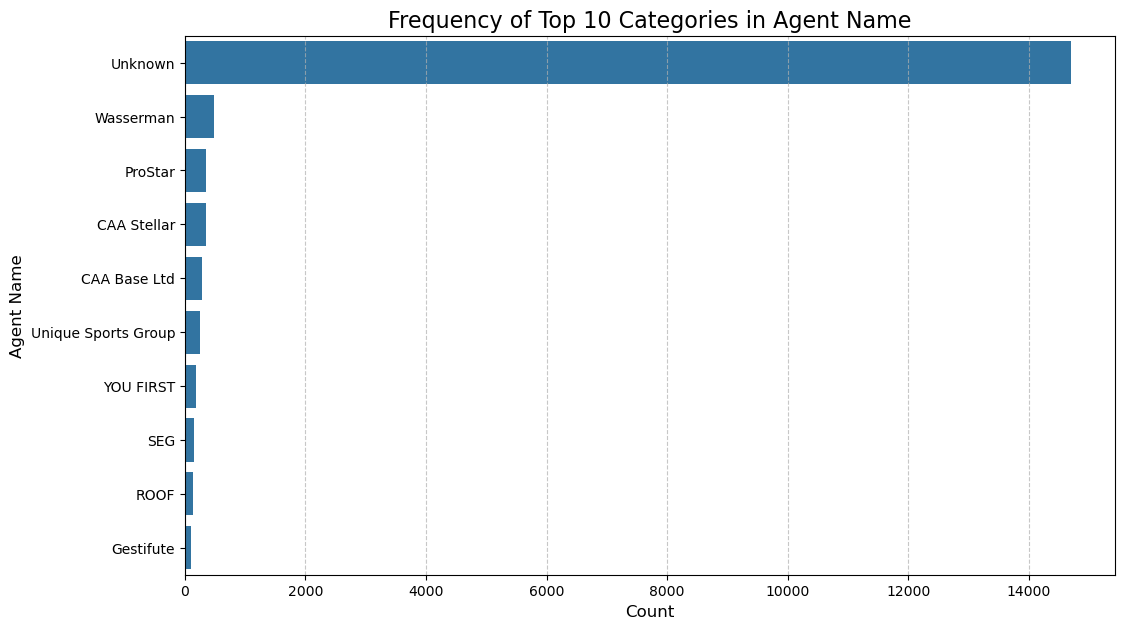

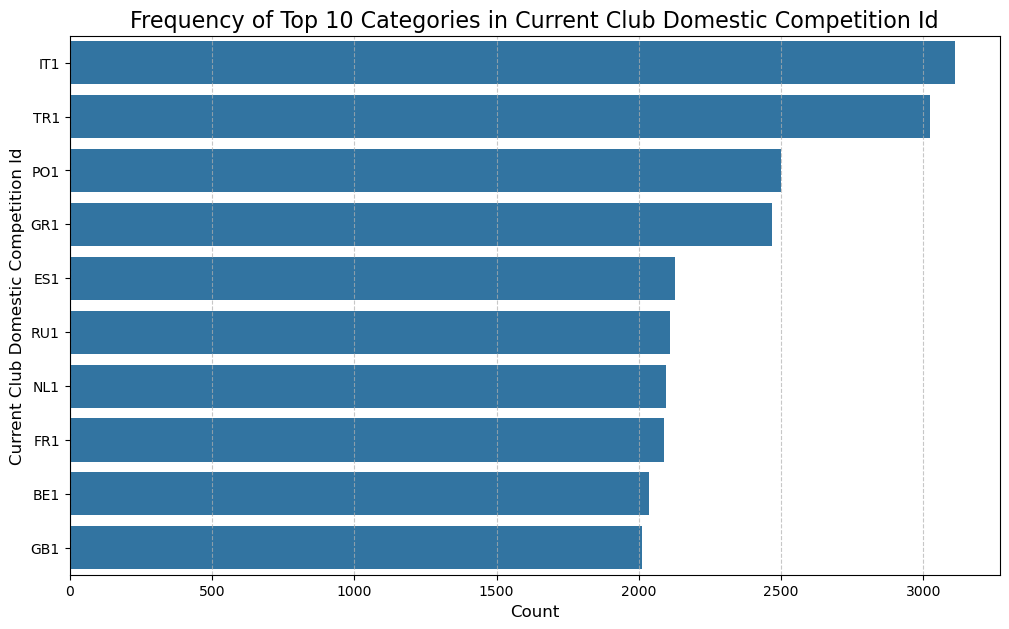

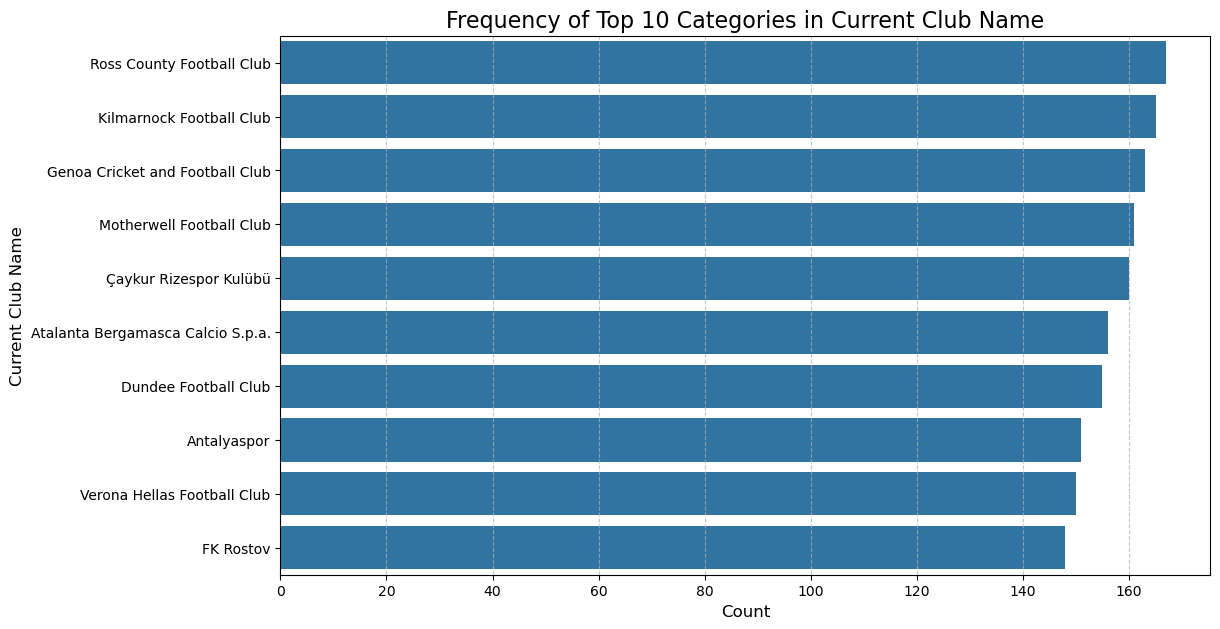

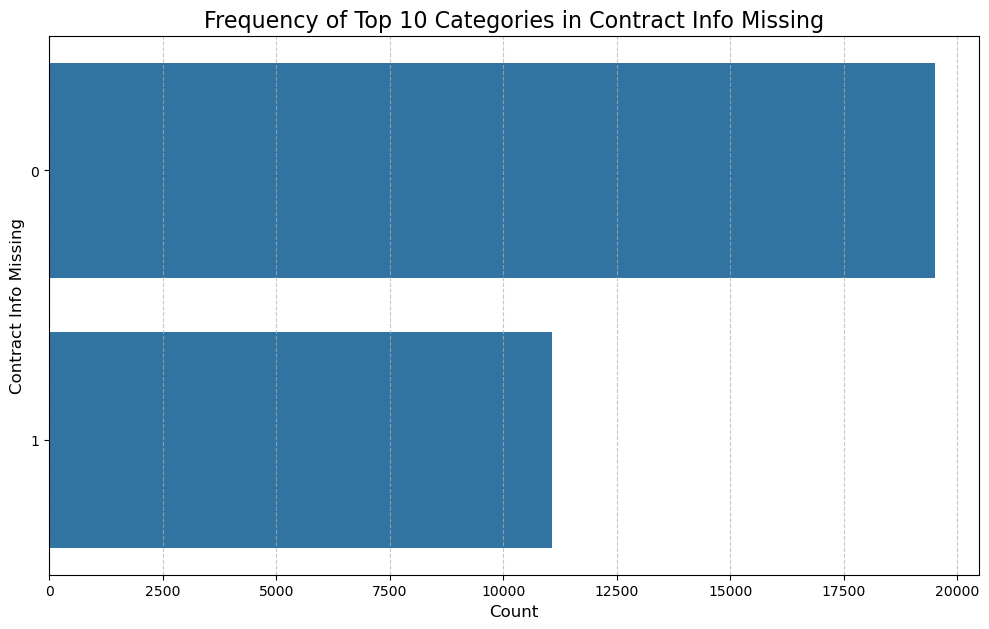

In [41]:
for col in cat_cols:

    top_categories = players_df[col].value_counts().nlargest(10).index
    
    plt.figure(figsize=(12, 7))
    sns.countplot(y=col, data=players_df, order=top_categories)
    plt.title(f'Frequency of Top 10 Categories in {col.replace("_", " ").title()}', fontsize=16)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel(col.replace("_", " ").title(), fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

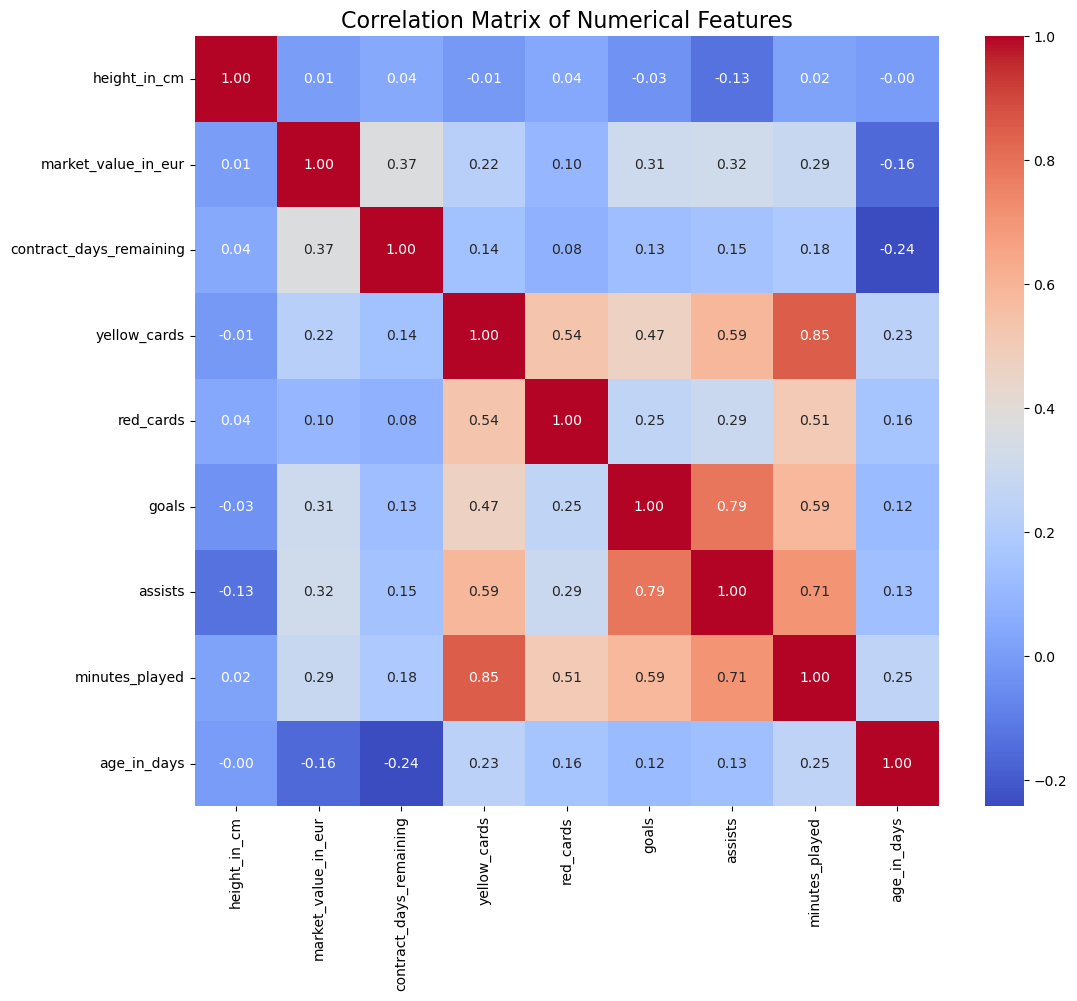

In [42]:
corr_matrix = players_df[num_cols].corr()

plt.figure(figsize=(12, 10))

sns.heatmap(
    corr_matrix, 
    annot=True,    
    cmap='coolwarm',
    fmt=".2f"       
)

plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()


## Modeling

In [43]:
model_df = players_df.drop(columns=['player_id', 'name', 'last_season','current_club_id'])

In [44]:
model_df = model_df.drop(columns=['agent_name'])

In [45]:
X = model_df.drop('market_value_in_eur', axis=1)
y = model_df['market_value_in_eur']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
def fit_evaluate_and_tune_model(X_train, X_test, y_train, y_test, model_class, num_cols, cat_cols, log_transform_target=False):
    """
    Trains, evaluates, and optionally tunes a model using pre-split data.

    Args:
        X_train, X_test, y_train, y_test: The pre-split training and testing data.
        model_class: The model class to be used.
        num_cols (list): List of numerical column names.
        cat_cols (list): List of categorical column names.
        log_transform_target (bool): If True, applies a log(1+x) transform to the target.

    Returns:
        tuple: The final (best) pipeline and its test scores (R-squared, RMSE).
    """
    
    # --- Set up a more robust warning filter ---
    warnings.filterwarnings("ignore", category=UserWarning, message=".*Found unknown categories.*")
    warnings.filterwarnings("ignore", category=FutureWarning)

    try:
        # --- 1. Initial Setup ---
        # Make copies to avoid modifying the original dataframes passed to the function
        X_train_processed = X_train.copy()
        X_test_processed = X_test.copy()
        y_train_processed = y_train.copy()
        y_test_processed = y_test.copy()

        # --- Apply Log Transform if requested ---
        if log_transform_target:
            print("\nApplying log transform to the target variable.")
            y_train_processed = np.log1p(y_train_processed)
            y_test_processed = np.log1p(y_test_processed)
        
        # --- Data Validation Step ---
        for col in num_cols:
            if col in X_train_processed.columns:
                X_train_processed[col] = pd.to_numeric(X_train_processed[col], errors='coerce')
                X_test_processed[col] = pd.to_numeric(X_test_processed[col], errors='coerce')

        # --- 2. Define Preprocessing Pipeline ---
        numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
        categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])
        
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, num_cols),
                ('cat', categorical_transformer, cat_cols)
            ],
            remainder='drop'
        )
        
        # --- 3. Evaluate Default Model ---
        default_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model_class(random_state=42) if 'random_state' in model_class().get_params() else model_class())
        ])
        
        default_pipeline.fit(X_train_processed, y_train_processed)
        y_pred_test_default = default_pipeline.predict(X_test_processed)
        y_pred_train_default = default_pipeline.predict(X_train_processed)

        # --- Inverse transform predictions if target was logged ---
        y_test_eval = np.expm1(y_test_processed) if log_transform_target else y_test_processed
        y_pred_test_eval = np.expm1(y_pred_test_default) if log_transform_target else y_pred_test_default
        y_train_eval = np.expm1(y_train_processed) if log_transform_target else y_train_processed
        y_pred_train_eval = np.expm1(y_pred_train_default) if log_transform_target else y_pred_train_default

        r2_test_default = r2_score(y_test_eval, y_pred_test_eval)
        rmse_test_default = np.sqrt(mean_squared_error(y_test_eval, y_pred_test_eval))
        r2_train_default = r2_score(y_train_eval, y_pred_train_eval)
        rmse_train_default = np.sqrt(mean_squared_error(y_train_eval, y_pred_train_eval))
        
        print(f"\n--- Initial {model_class.__name__} Evaluation ---")
        print(f"R-squared on Test Data: {r2_test_default:.2f}")
        print(f"R-squared on Training Data: {r2_train_default:.2f}")
        print(f"RMSE on Test Data: {rmse_test_default:,.2f}")
        print(f"RMSE on Training Data: {rmse_train_default:,.2f}")

        final_pipeline = default_pipeline
        final_r2 = r2_test_default
        final_rmse = rmse_test_default

        # --- 4. Conditional Hyperparameter Tuning ---
        if model_class in [RandomForestRegressor, XGBRegressor]:
            print("\n--- Starting Hyperparameter Tuning ---")
            
            # Define Model-Specific Parameter Grids
            if model_class == RandomForestRegressor:
                param_dist = {
                    'regressor__n_estimators': [100, 200, 500], 'regressor__max_depth': [10, 20, 30, None],
                    'regressor__min_samples_leaf': [1, 2, 4], 'regressor__max_features': ['sqrt', 'log2']
                }
            elif model_class == XGBRegressor:
                param_dist = {
                    'regressor__n_estimators': [100, 500, 1000], 'regressor__max_depth': [3, 5, 7, 10],
                    'regressor__learning_rate': [0.01, 0.05, 0.1], 'regressor__min_child_weight': [1, 5, 10]
                }

            # Randomized Search
            random_search = RandomizedSearchCV(estimator=default_pipeline, param_distributions=param_dist, n_iter=25, cv=5, verbose=1, random_state=42, n_jobs=-1)
            random_search.fit(X_train_processed, y_train_processed)
            print("\nBest parameters from Randomized Search:", random_search.best_params_)

            # Grid Search
            best_params = random_search.best_params_
            param_grid = {}
            for key, value in best_params.items():
                if key in ['regressor__n_estimators']:
                    step = max(100, int(value * 0.2))
                    param_grid[key] = sorted(list(set([value, max(50, value - step), value + step])))
                elif isinstance(value, int) and value >= 1:
                    param_grid[key] = [value - 1, value, value + 1]
                elif isinstance(value, float):
                    lower_bound = max(0.0, value * 0.9)
                    upper_bound = min(1.0, value * 1.1)
                    param_grid[key] = [lower_bound, value, upper_bound]
                else:
                    param_grid[key] = [value]
            
            grid_search = GridSearchCV(estimator=default_pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
            grid_search.fit(X_train_processed, y_train_processed)
            print("\nBest parameters from Grid Search:", grid_search.best_params_)
            
            # Overwrite final results with the tuned model's performance
            final_pipeline = grid_search.best_estimator_
            y_pred_test_tuned = final_pipeline.predict(X_test_processed)
            y_pred_train_tuned = final_pipeline.predict(X_train_processed)
            
            # Inverse transform predictions if target was logged
            y_test_eval = np.expm1(y_test_processed) if log_transform_target else y_test_processed
            y_pred_test_tuned_eval = np.expm1(y_pred_test_tuned) if log_transform_target else y_pred_test_tuned
            y_train_eval = np.expm1(y_train_processed) if log_transform_target else y_train_processed
            y_pred_train_tuned_eval = np.expm1(y_pred_train_tuned) if log_transform_target else y_pred_train_tuned

            final_r2 = r2_score(y_test_eval, y_pred_test_tuned_eval)
            final_rmse = np.sqrt(mean_squared_error(y_test_eval, y_pred_test_tuned_eval))
            r2_train_tuned = r2_score(y_train_eval, y_pred_train_tuned_eval)
            rmse_train_tuned = np.sqrt(mean_squared_error(y_train_eval, y_pred_train_tuned_eval))
            
            print(f"\n--- Tuned {model_class.__name__} Evaluation ---")
            print(f"R-squared on Test Data: {final_r2:.2f}")
            print(f"R-squared on Training Data: {r2_train_tuned:.2f}")
            print(f"RMSE on Test Data: {final_rmse:,.2f}")
            print(f"RMSE on Training Data: {rmse_train_tuned:,.2f}")
            
        return final_pipeline, final_r2, final_rmse
    finally:
        warnings.resetwarnings()

# 1. Define feature lists
numerical_features = [
    'height_in_cm', 'contract_days_remaining', 'yellow_cards', 
    'red_cards', 'goals', 'assists', 'minutes_played', 'age_in_days'
]
categorical_features = [
    'country_of_birth', 'country_of_citizenship',
    'sub_position', 'position', 'foot',
    'current_club_domestic_competition_id', 'current_club_name', 
    'contract_info_missing'
]

# 2. Create the train-test split
X = model_df.drop('market_value_in_eur', axis=1)
y = model_df['market_value_in_eur']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 3. Run all experiments using the same data split
print("\n--- EXPERIMENT 1: MODELS WITH ORIGINAL TARGET ---")
lr_pipeline, lr_r2, lr_rmse = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, LinearRegression, numerical_features, categorical_features
)
rf_pipeline, rf_r2, rf_rmse = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, RandomForestRegressor, numerical_features, categorical_features
)
xgb_pipeline, xgb_r2, xgb_rmse = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, XGBRegressor, numerical_features, categorical_features
)


print("\n--- EXPERIMENT 2: MODELS WITH LOG-TRANSFORMED TARGET ---")
lr_pipeline_log, lr_r2_log, lr_rmse_log = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, LinearRegression, numerical_features, categorical_features, log_transform_target=True
)
rf_pipeline_log, rf_r2_log, rf_rmse_log = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, RandomForestRegressor, numerical_features, categorical_features, log_transform_target=True
)
xgb_pipeline_log, xgb_r2_log, xgb_rmse_log = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, XGBRegressor, numerical_features, categorical_features, log_transform_target=True
)


--- EXPERIMENT 1: MODELS WITH ORIGINAL TARGET ---

--- Initial LinearRegression Evaluation ---
R-squared on Test Data: 0.35
R-squared on Training Data: 0.38
RMSE on Test Data: 5,099,225.68
RMSE on Training Data: 5,103,652.35

--- Initial RandomForestRegressor Evaluation ---
R-squared on Test Data: 0.64
R-squared on Training Data: 0.96
RMSE on Test Data: 3,794,145.19
RMSE on Training Data: 1,346,143.81

--- Starting Hyperparameter Tuning ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=80746) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWa


Best parameters from Randomized Search: {'regressor__n_estimators': 500, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'sqrt', 'regressor__max_depth': None}
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=80746) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Exception ignored in: <function ResourceTracker.__del__ at 0x107de9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3


Best parameters from Grid Search: {'regressor__max_depth': None, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 500}

--- Tuned RandomForestRegressor Evaluation ---
R-squared on Test Data: 0.57
R-squared on Training Data: 0.95
RMSE on Test Data: 4,123,326.73
RMSE on Training Data: 1,486,535.28

--- Initial XGBRegressor Evaluation ---
R-squared on Test Data: 0.69
R-squared on Training Data: 0.97
RMSE on Test Data: 3,491,597.08
RMSE on Training Data: 1,200,141.84

--- Starting Hyperparameter Tuning ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=80746) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWa


Best parameters from Randomized Search: {'regressor__n_estimators': 1000, 'regressor__min_child_weight': 10, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1}
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: 

KeyboardInterrupt: 

### Target

#### --- Initial LinearRegression Evaluation ---

R-squared on Test Data: 0.35

R-squared on Training Data: 0.38

RMSE on Test Data: 5,099,225.68

RMSE on Training Data: 5,103,652.35

Performance Drop (Overfitting): 0.03

Difference (Overfitting Gap): -4,426.68

#### --- Tuned RandomForestRegressor Evaluation ---

R-squared on Test Data: 0.57

R-squared on Training Data: 0.95

RMSE on Test Data: 4,123,241.51

RMSE on Training Data: 1,487,023.69

Performance Drop (Overfitting): 0.37

Difference (Overfitting Gap): 2,636,217.82

#### --- Tuned XGBRegressor Evaluation ---

R-squared on Test Data: 0.69

R-squared on Training Data: 0.94

RMSE on Test Data: 3,490,884.15

RMSE on Training Data: 1,585,374.41

Performance Drop (Overfitting): 0.25

Difference (Overfitting Gap): 1,905,509.74

### Log of Target

#### --- Initial LinearRegression Evaluation ---

R-squared on Test Data: 0.27

R-squared on Training Data: -0.01

RMSE on Test Data: 5,382,641.64

RMSE on Training Data: 6,519,661.41

Performance Drop (Overfitting): -0.28

Difference (Overfitting Gap): -1,137,019.77

#### --- Tuned RandomForestRegressor Evaluation ---

R-squared on Test Data: 0.37

R-squared on Training Data: 0.80

RMSE on Test Data: 5,013,766.80

RMSE on Training Data: 2,898,288.75

Performance Drop (Overfitting): 0.43

Difference (Overfitting Gap): 2,115,478.05

#### --- Tuned XGBRegressor Evaluation ---

R-squared on Test Data: 0.70

R-squared on Training Data: 0.90

RMSE on Test Data: 3,446,698.97

RMSE on Training Data: 2,076,673.28

Performance Drop (Overfitting): 0.20

Difference (Overfitting Gap): 1,370,025.69

#### Key Findings

XGBoost is the Top-Performing Model: Across all experiments, the XGBoost model consistently delivered the best results on the unseen test data.

Log Transformation is Effective for XGBoost: The best overall performance was achieved by the Tuned XGBoost model using the log-transformed target. This combination yielded the highest R-squared score (0.70) and the lowest Root Mean Squared Error (€3,446,699).

Log Transformation Reduces Overfitting: A key insight is that the log transform improved the XGBoost model's ability to generalize. It reduced the "Performance Drop" (the gap between training and test R-squared) from 0.25 to 0.20, indicating a more robust and reliable model.

Random Forest Performance Degraded with Log Transform: Interestingly, the performance of the RandomForestRegressor was worse when using the log-transformed target (R² dropped from 0.57 to 0.37). This suggests that for this specific dataset, the Random Forest model was leveraging the original scale of the target variable in its decision trees.

Linear Regression is Not Suitable: As confirmed by the low R-squared scores in both scenarios, a LinearRegression model is not capable of capturing the complex, non-linear patterns present in this dataset.

Final Recommendation
Based on this comprehensive analysis, the final recommended model is the Tuned XGBoost Regressor trained on the log-transformed market_value_in_eur target variable.

This model provides the best balance of predictive accuracy and generalization, explaining 70% of the variance in player market value while demonstrating the least amount of overfitting among the high-performing models.

Higher profile Premier League teams would not be very interested in players below a certain market value. If we filter out players under €10M, maybe we can improve performance

In [ ]:
high_val_df = model_df[model_df['market_value_in_eur'] > 10000000]

In [ ]:
model_df['market_value_in_eur'].mean(), model_df['market_value_in_eur'].std()

In [ ]:
high_val_df['market_value_in_eur'].mean(), high_val_df['market_value_in_eur'].std()

In [ ]:
X_2 = high_val_df.drop('market_value_in_eur', axis=1)
y_2 = high_val_df['market_value_in_eur']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

In [ ]:
xgb_pipeline2, xgb_r2, xgb_rmse2 = fit_evaluate_and_tune_model(X_train_2, X_test_2, y_train_2, y_test_2, XGBRegressor, numerical_features, categorical_features, log_transform_target=True)

In [ ]:
#New model with market values showed decreased performance

In [ ]:
# 1. Access the trained XGBoost model and the preprocessor from the pipeline
xgb_model = xgb_pipeline_t.named_steps['regressor']
preprocessor = xgb_pipeline_t.named_steps['preprocessor']

# 2. Get the feature names after all transformations (like one-hot encoding)
# This is crucial for matching the scores to the correct feature names
feature_names = preprocessor.get_feature_names_out()

# 3. Get the feature importance scores from the model
importances = xgb_model.feature_importances_

# 4. Create a pandas Series for easy viewing and sorting
feature_importance_series = pd.Series(importances, index=feature_names)

# 5. Sort the values to see the most important features at the top
print("--- Top 15 Most Important Features (from XGBoost) ---")
print(feature_importance_series.nlargest(15))

In [ ]:
# --- 1. Prepare Data for Analysis --
# Make predictions on the test set
y_pred_log = xgb_pipeline_t.predict(X_test)

# Inverse transform predictions and actuals to their original euro scale
y_pred_eur = np.expm1(y_pred_log)
y_test_eur = np.expm1(y_test)

# Create a new DataFrame for analysis to avoid SettingWithCopyWarning
analysis_df = X_test.copy()
analysis_df['actual_market_value'] = y_test_eur
analysis_df['predicted_market_value'] = y_pred_eur
analysis_df['residual_error'] = analysis_df['actual_market_value'] - analysis_df['predicted_market_value']

# Convert age back from days to years for easier interpretation
analysis_df['age'] = (analysis_df['age_in_days'] / 365.25).round(1)


# --- 2. Analyze the Residuals (Plotting) ---
# A residual plot shows the errors vs. a feature

plt.figure(figsize=(12, 7))
sns.scatterplot(x='age', y='residual_error', data=analysis_df, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Error vs. Player Age', fontsize=16)
plt.xlabel('Player Age (Years)', fontsize=12)
plt.ylabel('Prediction Error (Actual - Predicted) in EUR', fontsize=12)
plt.grid(True)
plt.show()


# --- 3. Examine the Biggest Misses ---
analysis_df = analysis_df.merge(players_df[['name']], left_index=True, right_index=True, how='left')

# Sort by the absolute error to find the biggest misses overall
analysis_df['abs_error'] = analysis_df['residual_error'].abs()
biggest_misses = analysis_df.sort_values('abs_error', ascending=False)

# Display the top 20 biggest prediction errors
print("--- Top 20 Biggest Prediction Misses ---")
display_cols = ['name', 'age', 'actual_market_value', 'predicted_market_value', 'residual_error']
print(biggest_misses[display_cols].head(20))


print("\n--- Top 10 Players the Model UNDERESTIMATED (Predicted too low) ---")
print(biggest_misses.sort_values('residual_error', ascending=False)[display_cols].head(10))

print("\n--- Top 10 Players the Model OVERESTIMATED (Predicted too high) ---")
print(biggest_misses.sort_values('residual_error', ascending=True)[display_cols].head(10))